<a href="https://colab.research.google.com/github/Raphahausen/2021-1-exercicio-revisao-refatoracao/blob/main/AlgII_tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raphaela Maria Costa e Silva - 2020006973

---



# Introdução
A proposta do trabalho foi criar um modelo de classificação em aprendizado supervisionado. O algoritmo foi implementado da seguinte forma: 
Primeiro foi feito uma envoltória convexa para cada rótulo e foi checado se as envoltórias se interceptavam, caso sim as classes não eram linearmente separáveis, sendo assim impossível criar tal modelo. Caso não se interceptassem, é linearmente separável e portanto é possível criar o modelo.
O modelo foi criado usando o segmento criado a partir dos vértices mais perto de cada envoltória, e o modelo foi a linha perpendicular à mediana desse segmento. Desse modo, o algoritmo criado para tal problema ajusta o modelo linear para os dados.
 




## Envoltória
Para fazer a envoltória convexa foi usado o algoritmo Wrapping.
Foram usadas a classe Point para representar os pontos. O algoritmo foi realizado da seguinte maneira, primeiro é achado o ponto mais à esquerda no plano cartesiano. Então os seguintes passos são repetidos até que seja achado o primeiro ponto novamente: acha o próximo ponto q que é anti horário em relação ao ponto anterior e ao próximo ponto, e se for encontrado outro ponto p mais anti horário que q, então q é substituído por p. O ponto final encontrado é o mais anti horário, pontanto ele será o próximo ponto na envoltória.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y


    def subtract(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'
        
def Left_index(points):
    # ponto mais a esquerda
    minn = 0
    for i in range(1,len(points)):
        if points[i].x < points[minn].x:
            minn = i
        elif points[i].x == points[minn].x:
            if points[i].y > points[minn].y:
                minn = i
    return minn
 
def orientation(p, q, r):
    # 0 colinear
    # 1 direita
    # 2 esquerda

    val = (q.y - p.y) * (r.x - q.x) - \
          (q.x - p.x) * (r.y - q.y)
 
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return 2


def convexHull(points, n):
     
    # se tiver 3 pontos
    if n < 3:
        return
 
    # acha o mais a esquerda
    l = Left_index(points)
 
    hull = []
     
    # olha os pontos para a esquerda
    p = l
    q = 0
    while(True):
         
        # adiciona ao resultado
        hull.append(p)
 
        q = (p + 1) % n
 
        for i in range(n):
             
            # Se for mais a esquerda que o q atual, atualiza
            if(orientation(points[p],
                           points[i], points[q]) == 2):
                q = i
        p = q
 
        if(p == l):
            break

    pontosl= []
    pontosx= []
    pontosy= []
    for each in hull:


        pontosl.append(Point(points[each].x, points[each].y))
        pontosx.append(points[each].x)
        pontosy.append(points[each].y)
    pontosx.append(pontosx[0])
    pontosy.append(pontosy[0])

    return pontosl, pontosx, pontosy
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Varredura Linear
Na varredura linear foram usadas as classes Segment, que tem dois pontos do segmento e uma tag para qual poligono o segmento pertence, Event que possui um ponto e se esse ponto é o começo de um segmento ou não e o índice original desse ponto.

In [ ]:
class Segment:

    def __init__(self, left, right, polygon):
        self.left = left
        self.right = right
        self.polygon = polygon

class Event:
    def __init__(self, x, y, l, i, sy):

        self.x = x
        self.y = y
        self.isLeft = l
        self.index = i
        self.lefty = sy
    def __lt__(self, e):
        if self.y == e.y:
            return self.x<e.y
        return self.y < e.y

def onSegment(p, q, r):
    if q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y):
        return True

    return False

def doIntersect(s1, s2):

    p1 = s1.left
    q1 = s1.right
    p2 = s2.left
    q2 = s2.right

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1,q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and onSegment (p1, p2, q1):
        return True

    if o2 == 0 and onSegment(p1, p2, q1):
        return True

    if o3 == 0 and onSegment(p1, p2, q1):
        return True

    if o4 == 0 and onSegment(p1, p2, q1):
        return True

    return False 


Para realizar a varredura linear primeiro foi ajustado os pontos recebidos da envoltória convexa, transformando os pontos das envoltórias em um array de segmentos. E então esses pontos são ordenados em relação à coordenada x e é criado uma BST vazia que vai conter os segmentos ativos do algoritmo. Em seguida, insere o ponto p na BST e é verificado se o ponto p é o início do segmento (isLeft == True), se é verifica se os segmentos mais próximos em cima e abaixo na BST interceptam o segmento do ponto p. Se p é o final do segmento, checa se os segmentos mais próximos em cima e abaixo na BST interceptam o segmento do ponto p e retira o segmento de p da BST.

In [ ]:
!pip install bintrees
import operator
from bintrees import AVLTree

def intersect(arr):
  e = []
  for i in range(0, len(arr)):
      e.append(Event(arr[i].left.x,arr[i].left.y, True,i, arr[i].left.y))
      e.append(Event(arr[i].right.x,arr[i].right.y, False,i, arr[i].left.y))

  e.sort( key=operator.attrgetter('x'))
  t = AVLTree()

  for i in e:
      index = i.index

      if(i.isLeft == True):
          if(len(t) > 1):
            b = t.max_key
            if(b() > index):
                next = t.ceiling_item(index)
            else:
                next = t.min_item()
            if(arr[next[1].index].polygon != arr[index].polygon):
               if(doIntersect(arr[next[1].index], arr[index])):
                    return True
            a = t.min_key
            if(a() < index):
                prev = t.floor_item(index) 
            else:
                prev = t.max_item()
            if(arr[prev[1].index].polygon != arr[index].polygon):
                if(doIntersect(arr[prev[1].index], arr[index])):
                    return True

          t.insert(index + i.lefty, i)

  if(i.isLeft == False):
      if(len(t) > 1):
          c = t.min_key
          if(c() < index):
              prev = t.floor_item(index) 
          else:
              prev = t.max_item()
          d = t.max_key
          if(d() > index):
              next = t.ceiling_item(index) 
          else:
              next = t.min_item()
          #if(next[0] != t.max_key() and prev[0] != t.max_item()):
          if (doIntersect(arr[prev[1].index], arr[next[1].index]) == 1 and arr[prev[1].index].polygon != arr[next[1].index].polygon):
              return True
          t.remove(index + i.lefty) 

  return False


def seg(pontos1, pontos2):
  pts1 = []
  pts2 = []
  for i in range (0, len(pontos1)-1):
    if(pontos1[i].x < pontos1[i+1].x):
        seg = Segment(pontos1[i],pontos1[i+1], 0)
        pts1.append(seg)
    else:
        seg = Segment(pontos1[i+1],pontos1[i], 0)
        pts1.append(seg)

  seg = Segment(pontos1[0],pontos1[len(pontos1)-1], 0)
  pts1.append(seg)

  for i in range (0, len(pontos2)-1):
    if(pontos2[i].x < pontos2[i+1].x):
        seg = Segment(pontos2[i],pontos2[i+1], 1)
        pts2.append(seg)
    else:
        seg = Segment(pontos2[i+1],pontos2[i], 1)
        pts2.append(seg)    
  seg = Segment(pontos2[0],pontos2[len(pontos2)-1], 1)
  pts2.append(seg)

  concat = pts2 + pts1  
  return concat


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Pontos mais próximos
Para achar os vértices mais próximos foi usado um algoritmo de força bruta  que para cada ponto em uma envoltória calcula a distância para todos os pontos na outra envoltória e retorna o par de pontos que possue a menor distância. Portanto esse algoritmo é O(n * m), em que n é o número de vértices em uma envoltória e m é o número de vértices na outra envoltória.

In [ ]:
import math
import copy
def dist(p1, p2):
    return math.sqrt((p1.x - p2.x) * 
                     (p1.x - p2.x) +
                     (p1.y - p2.y) * 
                     (p1.y - p2.y)) 
  
def mindist(pontos1, pontos0):
  distancia = float('inf')

  for i in range (0,len(pontos1)):
    for j in range (0, len(pontos0)):
      d = dist(pontos1[i], pontos0[j])
      if distancia > d:
        po1 = pontos1[i]
        po0 = pontos0[j]
        distancia = d
  return po0, po1


##Modelo
Para achar o modelo primeiro foi calculada a equação da reta R que une os pontos mais próximos e então foi calculada a equação da reta que é perpendicular a R e passa pelo ponto médio do segmento que une os pontos. Para achar a equação da reta é necessário achar m e coef tal que mx + coef = y.


In [ ]:
def modelo(po0, po1):
  mediax = (po0.x + po1.x)/2
  mediay = (po0.y + po1.y)/2
  if(po0.x - po1.x != 0):
    m1 = (po0.y - po1.y)/(po0.x - po1.x)
  else:
    m1 = (po0.y - po1.y/po0.x - po1.x + 0.0001)
  coef = (m1 * -po0.x) + po0.y
  if(m1 != 0):
      m2 = -1/m1
  else:
      mm2 = -1/0.00001
  coef1 = m2 * -mediax + mediay
  p0 = Point(mediax, mediay)
  p1 = Point(-coef1/m2 , 0)
  return p0,p1, m2,coef1

In [ ]:
def randpoints(a, b, c):
  points = []
  for i in range (0, c):
    points.append(Point(random.randint(a, b),random.randint(a, b)))
  return points



In [ ]:
from numpy import linspace


def teste(a, b ,c, d, e, f):
    points = randpoints(a,b,c)
    pontos0, pontosx0, pontosy0 = convexHull(points, len(points))

    points = randpoints(d,e,f)
    pontos1, pontosx1, pontosy1 = convexHull(points, len(points))

    arr = seg(pontos0, pontos1)

    erro = intersect(arr)

    po0, po1 = mindist(pontos0, pontos1)


    mediax, mediay, m, coef = modelo(po0, po1)

    def f(x): return m*x + coef  
    x = np.linspace(a,e)  
    plt.plot(x, f(x))

    plt.axis('equal') 
    plt.plot(pontosx0, pontosy0)
    plt.plot(pontosx1, pontosy1)
    plt.plot([po0.x, po1.x],[po0.y,po1.y])

    if(erro == 1):
      print("interceptam")
    else:
      print("nao interceptam")


interceptam


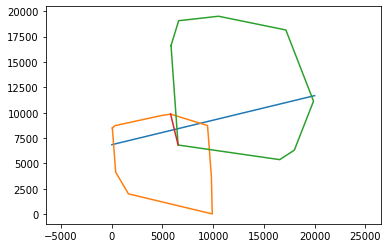

In [ ]:
teste(10, 10000, 30, 5000, 20000, 30)

interceptam


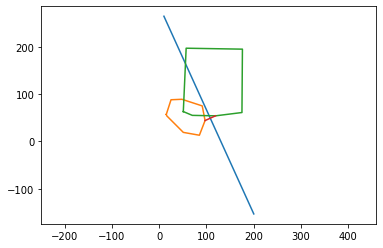

In [ ]:
teste(10, 100, 15, 50, 200, 15)

nao interceptam


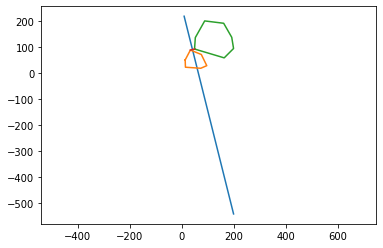

In [ ]:
teste(10, 100, 15, 50, 200, 15)

interceptam


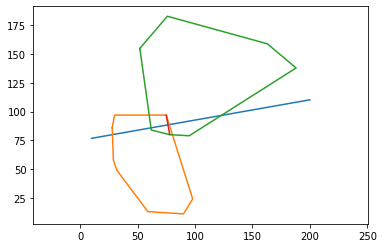

In [ ]:
teste(10, 100, 15, 50, 200, 15)

interceptam


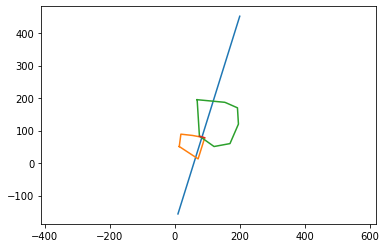

In [ ]:
teste(10, 100, 15, 50, 200, 15)

In [ ]:
def classificador(m, coef, pontos):
  for ponto in pontos:
      param = m*ponto[0]+coef
      if(param < ponto[1]):
          ponto[3] = 0
      if(param > ponto[1]):
          ponto[3] = 1
      else:
          ponto[3] = -1
def metricas(pontos):
    verdadeiro_positivo = 0
    verdadeiro_negativo = 0
    falso_positivo = 0
    falso_negativo = 0
    for ponto in pontos:
      if ponto[2] == ponto[3] and ponto[2] == 1:
        verdadeiro_positivo += verdadeiro_positivo
      if ponto[2] == ponto[3] and ponto[2] == 0:
        verdadeiro_negativo += verdadeiro_negativo
      if ponto[2] != ponto[3] and ponto[2] == 1:
        falso_positivo += falso_positivo
      if ponto[2] != ponto[3] and ponto[2] == 0:
        falso_negativo += falso_negativo



ModuleNotFoundError: ignored